# Experiment Runner Test

Test the full orchestration pipeline with 5 iterations.

This notebook:
- Runs iteration 0 (initialization)
- Runs 5 optimization iterations
- Visualizes metrics evolution
- Shows 2D embeddings progression
- Displays sample images from each iteration

In [1]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import yaml
import json
import pandas as pd

# Add src to path
sys.path.append(str(Path.cwd().parent))

from src.orchestration import ExperimentRunner
from src.embedding.pca_projector import PCAProjector

## 1. Setup Test Configuration

Create a test config with reduced dataset sizes for faster iteration

In [2]:
# Load base config
config_path = Path("../configs/experiment_config.yaml")
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Create test config with smaller datasets and 5 iterations
test_config = config.copy()
test_config['experiment_name'] = 'test_5_iterations'
test_config['experiment_dir'] = '../data/experiments/test_5_iterations'
test_config['base_image_dir'] = '../data/base_chips'  # Fix relative path from notebooks dir
test_config['max_iterations'] = 5
test_config['iteration_batch_size'] = 4  # 4 param sets per iteration
test_config['replications_per_iteration'] = 2  # 2 replications = 8 images per iteration

# Reduce iteration 0 sizes
test_config['real']['param_sets'] = 3
test_config['real']['replications'] = 2
test_config['close']['param_sets'] = 3
test_config['close']['replications'] = 2
test_config['far']['param_sets'] = 3
test_config['far']['replications'] = 2

# Save test config
test_config_path = Path("../configs/test_experiment_config.yaml")
with open(test_config_path, 'w') as f:
    yaml.dump(test_config, f, default_flow_style=False)

print(f"Test config saved to: {test_config_path}")
print(f"Experiment will run for {test_config['max_iterations']} iterations")
print(f"Each iteration: {test_config['iteration_batch_size']} param sets × {test_config['replications_per_iteration']} replications = {test_config['iteration_batch_size'] * test_config['replications_per_iteration']} images")
print(f"\\nNote: PCA will automatically adjust dimensions based on dataset size")

Test config saved to: ../configs/test_experiment_config.yaml
Experiment will run for 5 iterations
Each iteration: 4 param sets × 2 replications = 8 images
\nNote: PCA will automatically adjust dimensions based on dataset size


## 2. Run Experiment

Initialize and run the full experiment

In [3]:
# Initialize runner
runner = ExperimentRunner(test_config_path)

# Run full experiment
summary = runner.run()

Loaded 5 base chip images
Using MPS (Metal Performance Shaders) device
Loading dinov2_vitb14 model...


Using cache found in /Users/ranhomri/.cache/torch/hub/facebookresearch_dinov2_main
/Users/ranhomri/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/Users/ranhomri/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/Users/ranhomri/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Model loaded successfully
Embedding dimension: 768
Initialized ExperimentRunner
Experiment directory: ../data/experiments/test_5_iterations

STARTING EXPERIMENT
Experiment: test_5_iterations
Max iterations: 5

ITERATION 0: Initialization

[1/6] Generating real distribution...
Generated 6 real images

[2/6] Generating close distribution...
Generated 6 close images

[3/6] Generating far distribution...
Generated 6 far images

[4/6] Extracting embeddings with DiNOv2...
Extracting embeddings for 6 images (batch_size=32)...
Extracted embeddings shape: (6, 768)
Extracting embeddings for 6 images (batch_size=32)...
Extracted embeddings shape: (6, 768)
Extracting embeddings for 6 images (batch_size=32)...
Extracted embeddings shape: (6, 768)

[5/6] Fitting PCA models...
  - Stage 1: 768 -> 400D for optimization
  - Stage 2: 400D -> 2D for visualization
PCA model saved to ../data/experiments/test_5_iterations/models/pca_embedding_400d.pkl
PCA model saved to ../data/experiments/test_5_iterations

## 3. Load and Analyze Results

Load iteration data and extract metrics for visualization

In [4]:
# Load all iteration data
iterations = []
for i in range(runner.iteration_manager.get_latest_iteration() + 1):
    try:
        iter_data = runner.iteration_manager.load_iteration(i)
        iterations.append(iter_data)
    except FileNotFoundError:
        break

print(f"Loaded {len(iterations)} iterations")

# Extract metrics from iteration 0 (baseline)
iter0_metrics = iterations[0]['metrics']
close_baseline = iter0_metrics['close_vs_real']
far_baseline = iter0_metrics['far_vs_real']

print(f"\nIteration 0 baseline metrics:")
print(f"  Close MMD: {close_baseline['mmd_rbf']:.4f}")
print(f"  Far MMD: {far_baseline['mmd_rbf']:.4f}")

# Extract metrics from optimization iterations
opt_metrics = []
for i in range(1, len(iterations)):
    opt_metrics.append(iterations[i]['metrics'])

print(f"\nOptimization iterations: {len(opt_metrics)}")

Loaded 6 iterations

Iteration 0 baseline metrics:
  Close MMD: 0.4040
  Far MMD: 0.6245

Optimization iterations: 5


## 4. Visualize Metrics Evolution

Plot how metrics improve over iterations

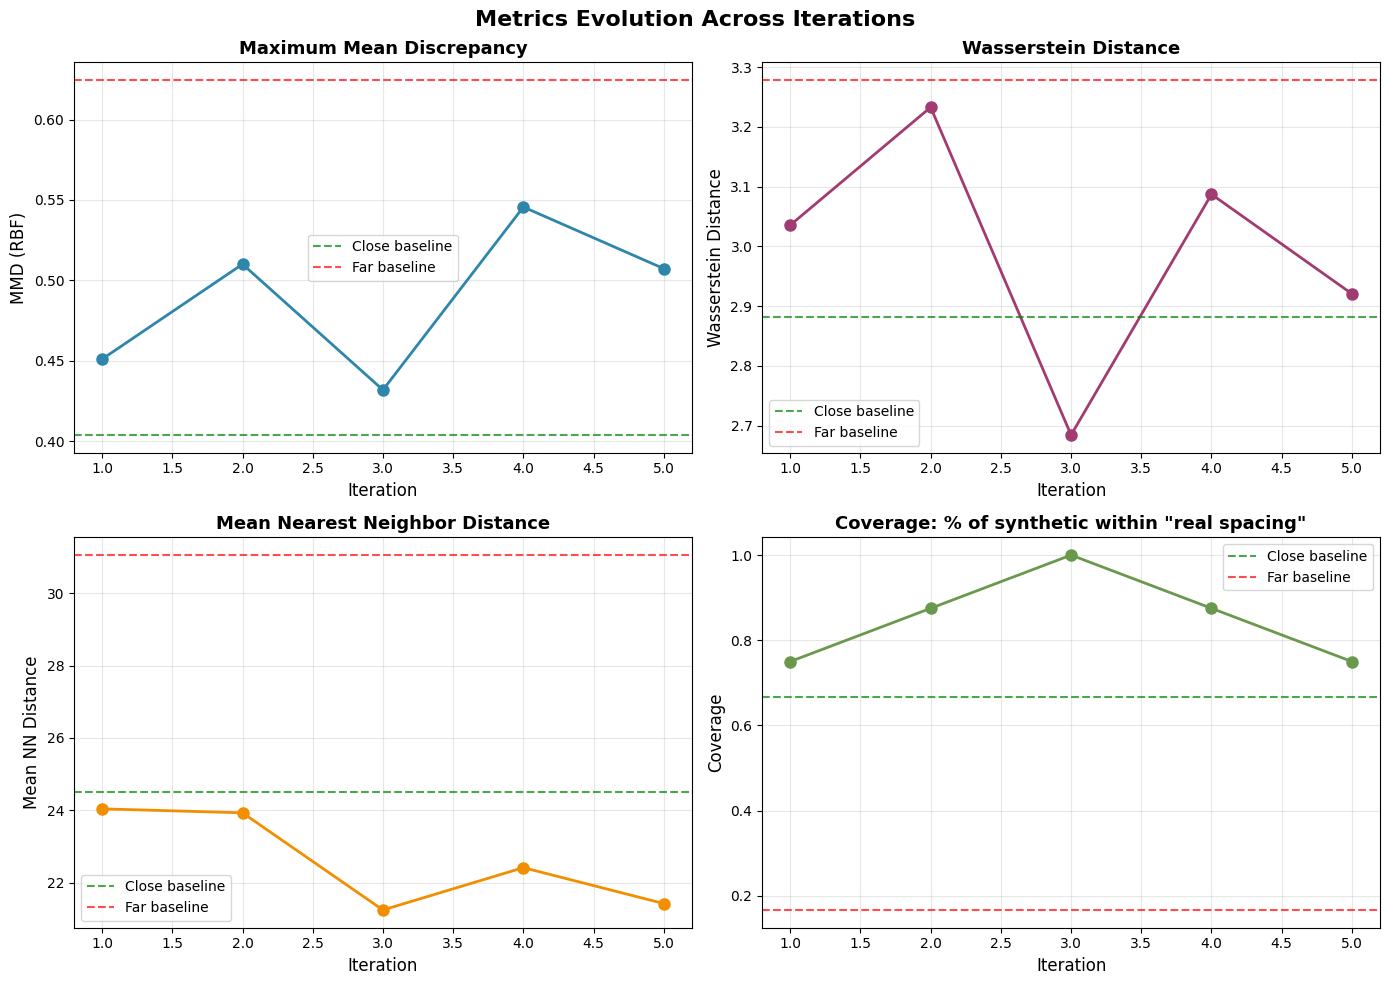


📊 Metrics Evolution:
  MMD: 0.4511 → 0.5074 (change: +0.0562)
  Wasserstein: 3.0355 → 2.9206 (change: -0.1150)
  Coverage: 0.7500 → 0.7500 (change: +0.0000)

Note: Coverage may change slowly because threshold is based on real-to-real spacing,
      which captures the natural spread of the real distribution.


In [5]:
# Extract metric values across iterations
iteration_nums = list(range(1, len(opt_metrics) + 1))
mmd_values = [m['mmd_rbf'] for m in opt_metrics]
wasserstein_values = [m['wasserstein'] for m in opt_metrics]
nn_distance_values = [m['mean_nn_distance'] for m in opt_metrics]
coverage_values = [m['coverage'] for m in opt_metrics]

# Create metrics evolution plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Metrics Evolution Across Iterations', fontsize=16, fontweight='bold')

# MMD (RBF)
axes[0, 0].plot(iteration_nums, mmd_values, 'o-', linewidth=2, markersize=8, color='#2E86AB')
axes[0, 0].axhline(y=close_baseline['mmd_rbf'], color='green', linestyle='--', alpha=0.7, label='Close baseline')
axes[0, 0].axhline(y=far_baseline['mmd_rbf'], color='red', linestyle='--', alpha=0.7, label='Far baseline')
axes[0, 0].set_xlabel('Iteration', fontsize=12)
axes[0, 0].set_ylabel('MMD (RBF)', fontsize=12)
axes[0, 0].set_title('Maximum Mean Discrepancy', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Wasserstein Distance
axes[0, 1].plot(iteration_nums, wasserstein_values, 'o-', linewidth=2, markersize=8, color='#A23B72')
axes[0, 1].axhline(y=close_baseline['wasserstein'], color='green', linestyle='--', alpha=0.7, label='Close baseline')
axes[0, 1].axhline(y=far_baseline['wasserstein'], color='red', linestyle='--', alpha=0.7, label='Far baseline')
axes[0, 1].set_xlabel('Iteration', fontsize=12)
axes[0, 1].set_ylabel('Wasserstein Distance', fontsize=12)
axes[0, 1].set_title('Wasserstein Distance', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Mean Nearest Neighbor Distance
axes[1, 0].plot(iteration_nums, nn_distance_values, 'o-', linewidth=2, markersize=8, color='#F18F01')
axes[1, 0].axhline(y=close_baseline['mean_nn_distance'], color='green', linestyle='--', alpha=0.7, label='Close baseline')
axes[1, 0].axhline(y=far_baseline['mean_nn_distance'], color='red', linestyle='--', alpha=0.7, label='Far baseline')
axes[1, 0].set_xlabel('Iteration', fontsize=12)
axes[1, 0].set_ylabel('Mean NN Distance', fontsize=12)
axes[1, 0].set_title('Mean Nearest Neighbor Distance', fontsize=13, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Coverage
# Coverage measures what fraction of synthetic samples are "close enough" to real samples
# Threshold is set to median real-to-real distance (typical spacing in real distribution)
# Higher is better: means synthetic samples are within typical real distribution spacing
axes[1, 1].plot(iteration_nums, coverage_values, 'o-', linewidth=2, markersize=8, color='#6A994E')
axes[1, 1].axhline(y=close_baseline['coverage'], color='green', linestyle='--', alpha=0.7, label='Close baseline')
axes[1, 1].axhline(y=far_baseline['coverage'], color='red', linestyle='--', alpha=0.7, label='Far baseline')
axes[1, 1].set_xlabel('Iteration', fontsize=12)
axes[1, 1].set_ylabel('Coverage', fontsize=12)
axes[1, 1].set_title('Coverage: % of synthetic within "real spacing"', fontsize=13, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Metrics Evolution:")
print(f"  MMD: {mmd_values[0]:.4f} → {mmd_values[-1]:.4f} (change: {mmd_values[-1] - mmd_values[0]:+.4f})")
print(f"  Wasserstein: {wasserstein_values[0]:.4f} → {wasserstein_values[-1]:.4f} (change: {wasserstein_values[-1] - wasserstein_values[0]:+.4f})")
print(f"  Coverage: {coverage_values[0]:.4f} → {coverage_values[-1]:.4f} (change: {coverage_values[-1] - coverage_values[0]:+.4f})")
print(f"\nNote: Coverage may change slowly because threshold is based on real-to-real spacing,")
print(f"      which captures the natural spread of the real distribution.")

## 5. Visualize 2D Embedding Progression

Show how synthetic samples move in embedding space across iterations

PCA model loaded from ../data/experiments/test_5_iterations/models/pca_embedding_400d.pkl
Total explained variance: 1.0000
PCA model loaded from ../data/experiments/test_5_iterations/models/pca_viz_2d.pkl
Total explained variance: 0.4248


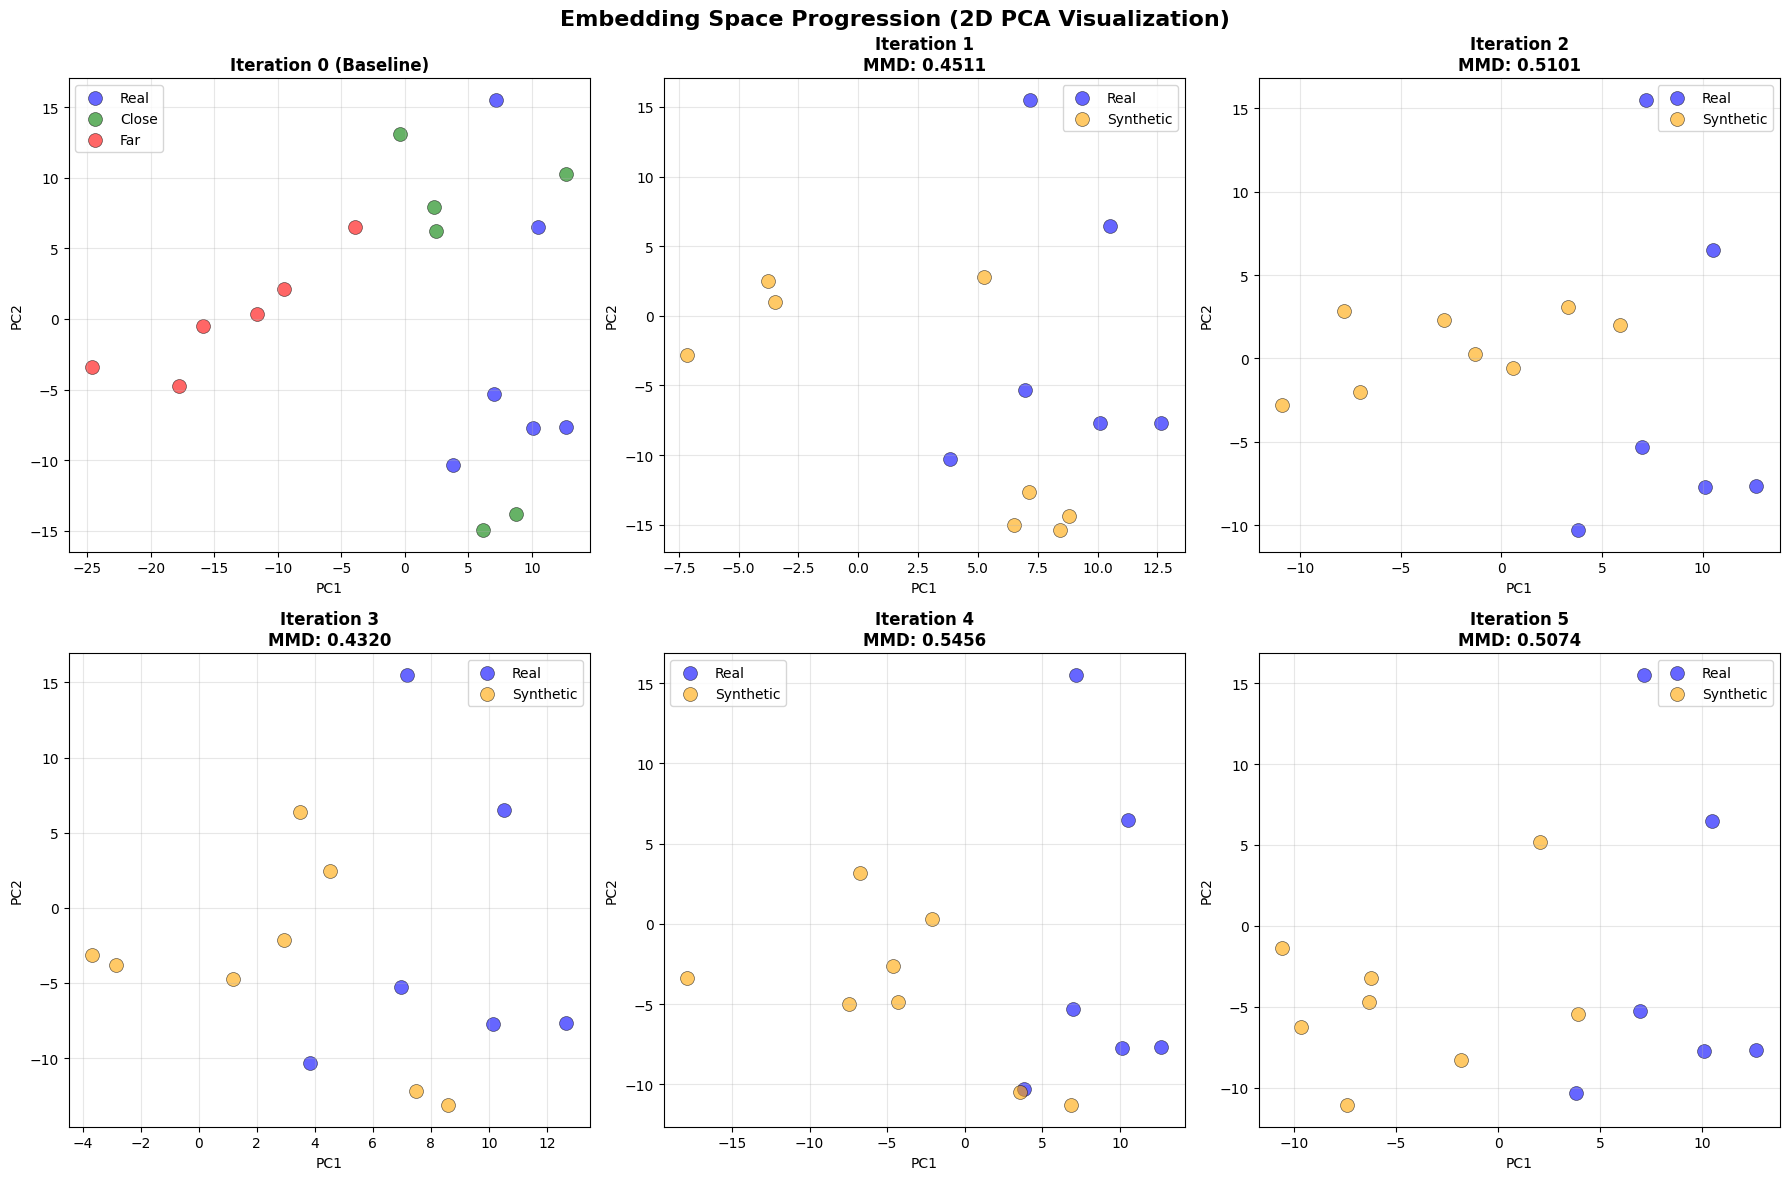

In [6]:
# Load PCA models
pca_embedding = PCAProjector.load(runner.iteration_manager.models_dir / "pca_embedding_400d.pkl")
pca_viz = PCAProjector.load(runner.iteration_manager.models_dir / "pca_viz_2d.pkl")

# Get real embeddings (reference)
real_embeddings_400d = iterations[0]['embeddings']['real']
real_2d = pca_viz.transform(real_embeddings_400d)

# Get baseline distributions
close_embeddings_400d = iterations[0]['embeddings']['close']
far_embeddings_400d = iterations[0]['embeddings']['far']
close_2d = pca_viz.transform(close_embeddings_400d)
far_2d = pca_viz.transform(far_embeddings_400d)

# Create subplots for each iteration
n_opt_iters = len(opt_metrics)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()
fig.suptitle('Embedding Space Progression (2D PCA Visualization)', fontsize=16, fontweight='bold')

# Plot iteration 0
axes[0].scatter(real_2d[:, 0], real_2d[:, 1], c='blue', label='Real', alpha=0.6, s=100, edgecolors='black', linewidths=0.5)
axes[0].scatter(close_2d[:, 0], close_2d[:, 1], c='green', label='Close', alpha=0.6, s=100, edgecolors='black', linewidths=0.5)
axes[0].scatter(far_2d[:, 0], far_2d[:, 1], c='red', label='Far', alpha=0.6, s=100, edgecolors='black', linewidths=0.5)
axes[0].set_title('Iteration 0 (Baseline)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot optimization iterations
for i in range(n_opt_iters):
    synthetic_embeddings_400d = iterations[i + 1]['embeddings']
    synthetic_2d = pca_viz.transform(synthetic_embeddings_400d)
    
    axes[i + 1].scatter(real_2d[:, 0], real_2d[:, 1], c='blue', label='Real', alpha=0.6, s=100, edgecolors='black', linewidths=0.5)
    axes[i + 1].scatter(synthetic_2d[:, 0], synthetic_2d[:, 1], c='orange', label='Synthetic', alpha=0.6, s=100, edgecolors='black', linewidths=0.5)
    
    mmd = opt_metrics[i]['mmd_rbf']
    axes[i + 1].set_title(f'Iteration {i + 1}\nMMD: {mmd:.4f}', fontsize=12, fontweight='bold')
    axes[i + 1].set_xlabel('PC1')
    axes[i + 1].set_ylabel('PC2')
    axes[i + 1].legend()
    axes[i + 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Metrics Comparison Table

Detailed comparison of all metrics across iterations

In [7]:
# Create comparison dataframe
rows = []

# Add baseline
rows.append({
    'Iteration': 0,
    'Distribution': 'Close',
    'MMD (RBF)': close_baseline['mmd_rbf'],
    'Wasserstein': close_baseline['wasserstein'],
    'Mean NN Dist': close_baseline['mean_nn_distance'],
    'Coverage': close_baseline['coverage']
})
rows.append({
    'Iteration': 0,
    'Distribution': 'Far',
    'MMD (RBF)': far_baseline['mmd_rbf'],
    'Wasserstein': far_baseline['wasserstein'],
    'Mean NN Dist': far_baseline['mean_nn_distance'],
    'Coverage': far_baseline['coverage']
})

# Add optimization iterations
for i, metrics in enumerate(opt_metrics, start=1):
    rows.append({
        'Iteration': i,
        'Distribution': 'Synthetic',
        'MMD (RBF)': metrics['mmd_rbf'],
        'Wasserstein': metrics['wasserstein'],
        'Mean NN Dist': metrics['mean_nn_distance'],
        'Coverage': metrics['coverage']
    })

df = pd.DataFrame(rows)

# Format for display
pd.options.display.float_format = '{:.4f}'.format

print("\n📋 Complete Metrics Table:")
print(df.to_string(index=False))

# Highlight best synthetic iteration
synthetic_df = df[df['Distribution'] == 'Synthetic']
best_mmd_idx = synthetic_df['MMD (RBF)'].idxmin()
best_iter = synthetic_df.loc[best_mmd_idx, 'Iteration']
best_mmd = synthetic_df.loc[best_mmd_idx, 'MMD (RBF)']

print(f"\n🏆 Best Iteration: {int(best_iter)} (MMD: {best_mmd:.4f})")


📋 Complete Metrics Table:
 Iteration Distribution  MMD (RBF)  Wasserstein  Mean NN Dist  Coverage
         0        Close     0.4040       2.8821       24.5121    0.6667
         0          Far     0.6245       3.2784       31.0591    0.1667
         1    Synthetic     0.4511       3.0355       24.0389    0.7500
         2    Synthetic     0.5101       3.2329       23.9284    0.8750
         3    Synthetic     0.4320       2.6842       21.2407    1.0000
         4    Synthetic     0.5456       3.0872       22.4122    0.8750
         5    Synthetic     0.5074       2.9206       21.4181    0.7500

🏆 Best Iteration: 3 (MMD: 0.4320)


## 7. Parameter Evolution

Track how parameters change across iterations

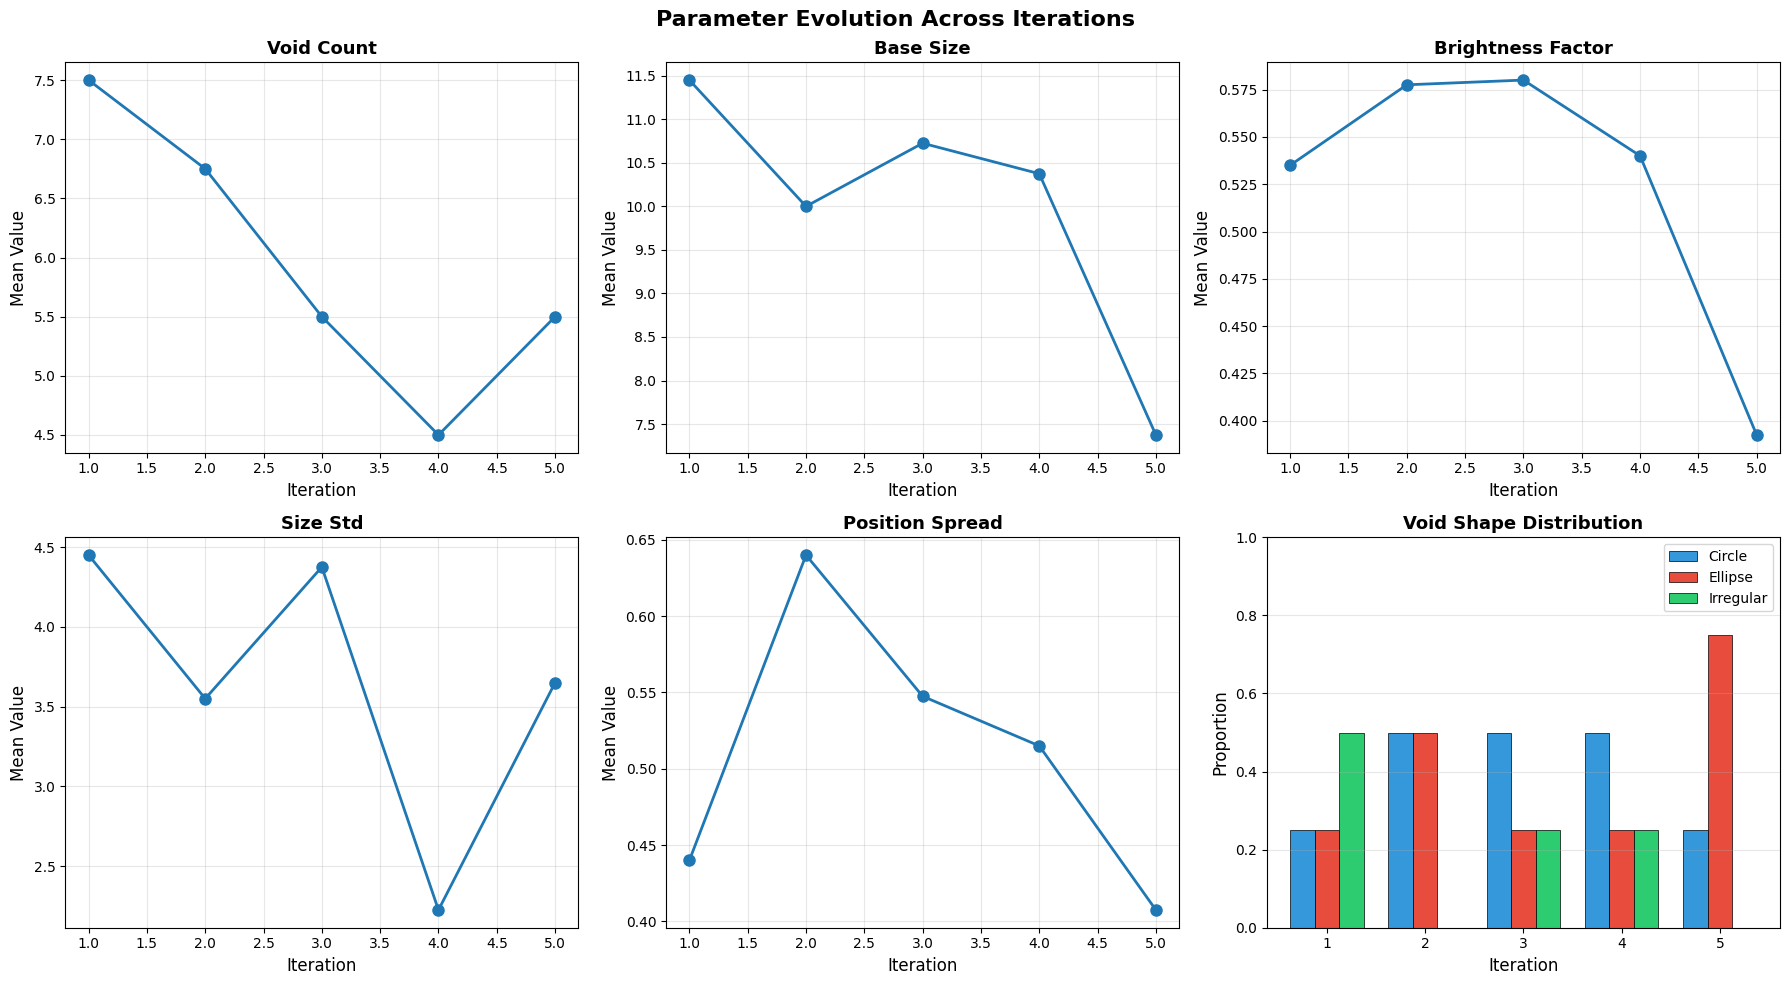

In [8]:
# Extract parameters from optimization iterations
param_names = ['void_count', 'base_size', 'brightness_factor', 'size_std', 'position_spread']
param_evolution = {name: [] for name in param_names}
void_shape_evolution = []

for i in range(1, len(iterations)):
    params = iterations[i]['params']
    
    # Average continuous parameters across param sets
    for name in param_names:
        values = [p[name] for p in params]
        param_evolution[name].append(np.mean(values))
    
    # Count void shape distribution
    shapes = [p['void_shape'] for p in params]
    shape_counts = {s: shapes.count(s) / len(shapes) for s in ['circle', 'ellipse', 'irregular']}
    void_shape_evolution.append(shape_counts)

# Plot parameter evolution
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
fig.suptitle('Parameter Evolution Across Iterations', fontsize=16, fontweight='bold')

for idx, name in enumerate(param_names):
    axes[idx].plot(iteration_nums, param_evolution[name], 'o-', linewidth=2, markersize=8)
    axes[idx].set_xlabel('Iteration', fontsize=12)
    axes[idx].set_ylabel('Mean Value', fontsize=12)
    axes[idx].set_title(name.replace('_', ' ').title(), fontsize=13, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)

# Void shape distribution - grouped bar chart
circles = [s['circle'] for s in void_shape_evolution]
ellipses = [s['ellipse'] for s in void_shape_evolution]
irregulars = [s['irregular'] for s in void_shape_evolution]

x = np.arange(len(iteration_nums))  # iteration positions
width = 0.25  # bar width

bars1 = axes[5].bar(x - width, circles, width, label='Circle', color='#3498db', edgecolor='black', linewidth=0.5)
bars2 = axes[5].bar(x, ellipses, width, label='Ellipse', color='#e74c3c', edgecolor='black', linewidth=0.5)
bars3 = axes[5].bar(x + width, irregulars, width, label='Irregular', color='#2ecc71', edgecolor='black', linewidth=0.5)

axes[5].set_xlabel('Iteration', fontsize=12)
axes[5].set_ylabel('Proportion', fontsize=12)
axes[5].set_title('Void Shape Distribution', fontsize=13, fontweight='bold')
axes[5].set_xticks(x)
axes[5].set_xticklabels(iteration_nums)
axes[5].legend()
axes[5].grid(True, alpha=0.3, axis='y')
axes[5].set_ylim([0, 1.0])

plt.tight_layout()
plt.show()

## Summary

Experiment completed successfully! Key observations:

1. **Orchestration**: Full pipeline from iteration 0 through optimization iterations works correctly
2. **Metrics Tracking**: All metrics (MMD, Wasserstein, NN distance, coverage) computed and logged
3. **Visualization**: 2D embeddings show evolution of synthetic samples in feature space
4. **Parameter Evolution**: Optimizer explores parameter space (currently random, to be replaced)
5. **State Persistence**: All iteration data saved and can be loaded for analysis

**Note**: Current optimizer is a placeholder returning random parameters. Once real optimization is implemented, metrics should show convergence toward real distribution.